In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tables
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton 
import calibrate
import pandas as pd
from scipy.special import erf
import glob
import re
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator, CubicSpline, PchipInterpolator, PPoly, interpolate
from scipy.signal import butter,filtfilt
from matplotlib.font_manager import FontProperties

In [2]:
# Compton Sensitivity
sim_particles = 1000000
mu_low, mu_high = -0.4, 1
lever_thres = 14
standoff = 40
solid = ( 74 * 74 ) / ( 4 * np.pi * standoff ** 2 + ( 2 * 74 * 74 ) )

comp = []
for file in glob.glob("/Users/eframe/geant4py/outsens/x*e*"):
    src = tables.open_file(file)
    rawdata = pd.DataFrame(src.root.raw.data[:])
    src.close()
    
    Es = int( re.search(r'40e(.*).h5', file).group(1) )
    
    # Doubles Filter for Compton Events  
    dmask = ( rawdata['detID'] < 2 )
    imask = ( rawdata['interaction'] >= 0 ) & ( rawdata['interaction'] <= 1 )
    data = rawdata[dmask][imask]
       
    smask = data.groupby(['eventID'])['trackID'].sum().values > 1 
    smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 2 # Doubles Events Only
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == Es
    
    gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
    gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
    gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
    
    gx2 = data.groupby(['eventID']).nth(1)['gx'][smask2][emask]
    gy2 = data.groupby(['eventID']).nth(1)['gy'][smask2][emask]
    gz2 = data.groupby(['eventID']).nth(1)['gz'][smask2][emask]
    
    pos1 = np.array([gx1, gy1, gz1]).T
    pos2 = np.array([gx2, gy2, gz2]).T
    
    E2 = data.groupby(['eventID']).nth(1)['E'][smask2][emask]
  
    coneMu = ( 1 + 511 * ( 1 / Es - 1 / E2 ) )
    mask2 = ( coneMu > mu_low ) & ( coneMu < mu_high )

    coneAxes = pos2 - pos1
    lever = np.sqrt( ( coneAxes ** 2 ).sum( axis = 1 ) )
    mask3 = lever[mask2] >= lever_thres

    # Computing sensitivity
    doubles = lever[mask2][mask3]
    sens = len(doubles) / sim_particles / solid
    
    comp.append([Es, sens])

In [3]:
# Coded Aperture Sensitivity
sim_particles = 1000000
standoff = 40
depth = 5
solid = ( 74 * 74 ) / ( 4 * np.pi * standoff ** 2 + ( 2 * 74 * 74 ) )

coded = []
for file in glob.glob("/Users/eframe/geant4py/outsens/x*z40*e*"):
    src = tables.open_file(file)
    rawdata = pd.DataFrame(src.root.raw.data[:])
    src.close()
    
    Es = int( re.search(r'40e(.*).h5', file).group(1) )
    
    dmask = ( rawdata['detID'] == 0 )
    imask = ( rawdata['interaction'][dmask] == 0 ) 
    data = rawdata[dmask][imask]
    
    smask = data.groupby(['eventID'])['trackID'].sum().values == 1 # Singles Events Only
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask] == Es
    
    gx1 = data.groupby(['eventID'])['gx'].first().values[smask][emask]
    gy1 = data.groupby(['eventID'])['gy'].first().values[smask][emask]
    gz1 = data.groupby(['eventID'])['gz'].first().values[smask][emask]
    
    maskz = np.abs(gz1) < depth
    pos1 = np.array([gx1, gy1, gz1]).T[maskz]
    
    # Computing sensitivity
    singles = pos1.copy()
    sens = ( len(singles) / sim_particles / solid ) * 0.5
    
    coded.append([Es, sens])

In [4]:
comp = np.array(comp)
coded = np.array(coded)
comp_sort = comp[comp[:,0].argsort(),:]
coded_sort = coded[coded[:,0].argsort(),:]

max_coded = np.argmax(coded_sort[:,1])
max_comp = np.argmax(comp_sort[:,1])

/Users/eframe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


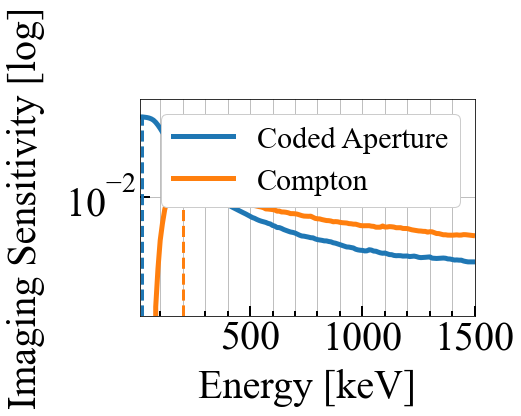

In [5]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel('Energy [keV]', fontsize=40, fontproperties=font, labelpad=10)
ax.set_ylabel('Imaging Sensitivity [log]', fontsize=40, fontproperties=font, labelpad=20)
ax.semilogy( coded_sort[:,0], coded_sort[:,1], linewidth=5, label='Coded Aperture')
ax.semilogy( comp_sort[:,0], comp_sort[:,1], linewidth=5, label='Compton')

ax.axvline( coded_sort[max_coded][0], color='tab:blue', ymin=0, ymax=0.92, 
           linestyle = '--', linewidth=3)
ax.axvline( comp_sort[max_comp][0], color='tab:orange', ymin=0, ymax=0.615, 
           linestyle = '--', linewidth=3)


ax.set_xlim(10,1500)
ax.set_ylim(0, 1)
ax.legend(prop={"family":"Times New Roman", 'size': 30}, framealpha=1 )
ax.tick_params(labelsize=40)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
plt.show()

In [6]:
data.groupby(['eventID'])['gx'].first().values

array([  2.3970807 ,  -0.17733406,  12.2727995 , ...,  33.0292    ,
        29.035881  , -21.293879  ], dtype=float32)

In [14]:
# Compton Sensitivity
sim_particles = 1000000
mu_low, mu_high = -0.4, 1
lever_thres = 14
standoff = 120
solid = ( 74 * 74 ) / ( 4 * np.pi * standoff ** 2 + ( 2 * 74 * 74 ) )

comp = []
for file in glob.glob("/Users/eframe/geant4py/output/x*z120*e*"):
    src = tables.open_file(file)
    rawdata = pd.DataFrame(src.root.raw.data[:])
    src.close()
    
    Es = int( re.search(r'120e(.*).h5', file).group(1) )
    
    # Total in Detected 
    total = len( rawdata.groupby(['eventID'])['gx'].first().values ) / ( sim_particles * solid )
    
    # Initial Filters
    dmask = rawdata['detID'].values < 2 
    data = rawdata[dmask]
    smask = data.groupby(['eventID'])['trackID'].sum().values >= 1
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask] == Es
    
    total_pp =  len( data.groupby(['eventID'])['gx'].first().values[smask][emask] ) / ( sim_particles * solid )
    
    # Doubles Filter for Compton Events
    dmask = ( rawdata['detID'] < 2 )
    imask = ( rawdata['interaction'] >= 0 ) & ( rawdata['interaction'] <= 1 )
    data = rawdata[dmask][imask]
    smask = data.groupby(['eventID'])['trackID'].sum().values > 1 
    smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 2 # Doubles Events Only
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == Es   
    gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
    gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
    gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
    
    gx2 = data.groupby(['eventID']).nth(1)['gx'][smask2][emask]
    gy2 = data.groupby(['eventID']).nth(1)['gy'][smask2][emask]
    gz2 = data.groupby(['eventID']).nth(1)['gz'][smask2][emask]
    
    pos1 = np.array([gx1, gy1, gz1]).T
    pos2 = np.array([gx2, gy2, gz2]).T
    
    doub_pp = len(pos1) / ( sim_particles * solid )
    
    E2 = data.groupby(['eventID']).nth(1)['E'][smask2][emask]
  
    coneMu = ( 1 + 511 * ( 1 / Es - 1 / E2 ) )
    mask2 = ( coneMu > mu_low ) & ( coneMu < mu_high )

    coneAxes = pos2 - pos1
    lever = np.sqrt( ( coneAxes ** 2 ).sum( axis = 1 ) )
    mask3 = lever[mask2] >= lever_thres

    # Computing sensitivity
    doubles = lever[mask2][mask3]
    sens = len(doubles) / ( sim_particles * solid )
    
    print([Es, total, total_pp, doub_pp, sens])

[662, 0.5446731274785485, 0.15633681776359573, 0.034519561868895265, 0.006132917083306265]


In [8]:
# Coded Aperture Sensitivity
sim_particles = 1000000
standoff = 180
depth = 5
solid = ( 74 * 74 ) / ( 4 * np.pi * standoff ** 2 + ( 2 * 74 * 74 ) )

coded = []
for file in glob.glob("/Users/eframe/geant4py/output/x*z180*e*"):
    src = tables.open_file(file)
    rawdata = pd.DataFrame(src.root.raw.data[:])
    src.close()
    
    Es = int( re.search(r'180e(.*).h5', file).group(1) )
    
    # Total in Detected 
    total = len( rawdata.groupby(['eventID'])['gx'].first().values ) / ( sim_particles * solid ) * 0.5
    
    dmask = ( rawdata['detID'] == 0 )
    data = rawdata[dmask]
    smask = data.groupby(['eventID'])['detID'].sum().values == 0
    smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] > 0   
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask] == Es
    
    total_pp =  len( data.groupby(['eventID'])['gx'].first().values[smask][emask] ) / ( sim_particles * solid ) * 0.5
    
    dmask = ( rawdata['detID'] == 0 )
    imask = ( rawdata['interaction'][dmask] == 0 ) 
    data = rawdata[dmask][imask]
    smask = data.groupby(['eventID'])['detID'].sum().values == 0 
    smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 1 # Singles Events Only
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == Es
    
    gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
    gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
    gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
    
    sing_pp = len(gx1) / ( sim_particles * solid ) * 0.5
    
    maskz = np.abs(gz1) < depth
    
    pos1 = np.array([gx1, gy1, gz1]).T[maskz]
    

    # Computing sensitivity
    singles = pos1
    sens = len(singles) / ( sim_particles * solid ) * 0.5
    
    coded.append([Es, sens])
    
    print([Es, total, total_pp, sing_pp, sens])

[122, 0.4649824076228806, 0.4040155024526228, 0.2765461872594538, 0.1779760249866888]


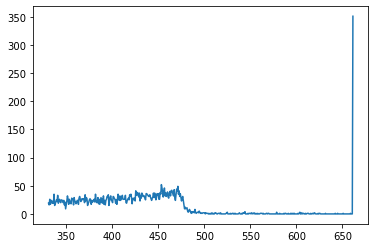

In [17]:
hist, bins = np.histogram(rawdata['E'], bins = 1000 )
plt.plot( bins[:-1][500:], hist[500:] )
plt.show()